# The Great Tohoku earthquake and the Fukushima Daiichi Accident

> The Fukushima nuclear disaster was the most severe nuclear accident since Chernobyl. Together, they have been the only ones with a level 7 classification on the International Nuclear and Radiological Event Scale. In 2011, an earthquake followed by a tsunami caused the disaster in the Japanese plant, and it all traces back to a mistake in the safety model.

- toc: false
- branch: master
- author: Michael Hotaling
- badges: true
- comments: true
- hide: false
- show_image: false
- hide_binder_badge: false
- hide_colab_badge: false

Japan is no stranger to earthquakes. The island itself is located at the converging point of four techtonic plates. As a result, the area experiences around 1,000 earthquakes a year, averaging about 3 a day. Most of these quakes go without any notice, the majority being below magnitude 5, but there is always the chance for much bigger quakes to occur.

In [1]:
#hide_input
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
#import geopandas as gpd
import folium
from IPython.core.display import display, HTML
from IPython.display import IFrame
import datetime

from bokeh.plotting import figure
from bokeh.io import output_file, show, save
from bokeh.sampledata.iris import flowers
from bokeh.models import Range1d, PanTool, ResetTool, HoverTool, ColumnDataSource


In [2]:
#hide_input
df = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

In [3]:
#hide_input
df['popup'] = pd.to_datetime(df['time']).dt.strftime("%Y-%m-%d") + ": Magnitude "+ df['mag'].astype(str) +" " +df['place']

In [4]:
#hide_input
# Loading the background map
eq_map = folium.Map(location=[df['latitude'].median(), 
                              df['longitude'].median()], zoom_start=5, tiles='Stamen Terrain', width=900,height = 650)
fg = folium.FeatureGroup(name="My Map")

# Adding a circle for each earthquake
for idx, eq in df.query('mag >= 6').iterrows():
    #folium.Circle(location=(eq['latitude'], eq['longitude']), radius=20000 * (eq['mag']-6), color='red', fill=False, alpha = 0.4).add_to(eq_map)
    fg.add_child(folium.CircleMarker(location=[eq['latitude'], 
                                               eq['longitude']], 
                                     radius=10 * (eq['mag']-5.7), 
                                     color = 'red', 
                                     fill_color='red', 
                                     alpha = 0.1,
                                     fill_opacity=0.1, 
                                     popup=eq['popup']
                                    )
                )
    
eq_map.add_child(fg)
folium.Circle(location = (37.4218, 141.0337), color = 'yellow', fill_color = 'yellow', radius = 2000, popup="Fukushima Daiichi", fill_opacity=0.4).add_to(eq_map);

In [5]:
#hide_input
eq_map.save("eq_map.html")

In [6]:
#hide_input
print("Interactive Map of Earthquakes near Japan. Made with Folium")
IFrame(src='eq_map.html', width=900, height=650)

Interactive Map of Earthquakes near Japan. Made with Folium


A magnitude 9.1 earthquake is an incredibly rare event in any part of the world and, according to the official position of the US Geological Survey, it is impossible to predict both time and location of such an event before it happens. This doesn't mean the probability of such an event can't be calculated though. The Gutenberg-Richter law states that the relationship between the magnitude of an earthquake and the logarithm of the probability that it happens is linear, so we can estimate the likeihood of such an event happening by creating a linear model

# The Fukushima Daiichi Nuclear Accident

I've read online that during the safety analysis, the engineers at Fukushima used historical earthquake data dating back to 1600 CE to build a regression model to determine the likelihood of significant earthquakes. Instead of using the accepted Gutenberg-Richter model, they saw a kink in the data and assumed the appropriate regression was not linear but polynomial. The resulting model assumed that a magnitude 9 and above earthquake was essentailly impossible, occuring once within a 19,000 year period. 

![](https://ml.berkeley.edu/blog/static/b9b73097351b54bbc36b593b633f2b5e/928e6/tut4_earthquake-overfit.webp)

I haven't found much evidence to support this other than a few sources such as [Berkeley Machine Learning Crash Course](https://ml.berkeley.edu/blog/posts/crash-course/part-4/) which cites a paper by Brian Stacey titled [Fukushima: The Failure of Predictive Models](https://mpra.ub.uni-muenchen.de/69383/1/MPRA_paper_69383.pdf) which then cites Nate Silver's book, *The Signal and the Noise: Why So Many Predictions Fail — but Some Don't* and a report by M.Ragheb titled [FUKUSHIMA EARTHQUAKE AND TSUNAMI STATION BLACKOUT ACCIDENT](https://mragheb.com/NPRE%20402%20ME%20405%20Nuclear%20Power%20Engineering/Fukushima%20Earthquake%20and%20Tsunami%20Station%20Blackout%20Accident.pdf)

What I can tell is that the station was not designed to widthstand a magnitude 9 earthquake. The 3/11 earthquakes produced a tsunami towering more than 14 meters (46 feet). The safety design team desgined the plan to be able to widthstand a magnitude 8.6, which would have generated a tsunami 5.7 meters tall, so the tsunami was easily able to breach the 6 meter tall seawall surrounding the plant. 

![](https://royalsocietypublishing.org/cms/asset/507e99af-2ff5-4acf-9179-0935fd11020f/rsta20140379f02.jpg) 

The assuption that these types of quakes were impossible wasn't uncommon. Emile Okal, a earthquake and tsunami expert explains some of the rational.

>Essentially, the feeling was that — if you had a very, very old ocean floor — when it was eventually recycled into the mantle of the Earth, you wouldn’t get these mega-earthquakes. 

In his book, Nate Silver uses data from January 1st, 1964 to March 11th, 2011 to recreate a similar polynomial model that the safety engineers have assumed to have used. Nate uses data from the US Geological Survey and pulls a 1 degree by 1 degree box of data around the origin of the 3/11 earthquake. We can use the USGS API to do the same

In [7]:
min_lat, max_lat = 38.32 - 0.5, 38.32 + 0.5
min_long, max_long = 142.37 - 0.5, 142.37 + 0.5
start_time = datetime.datetime(1964,1,1)
end_time = datetime.datetime(2011,3,11)
url = f"""\
https://earthquake.usgs.gov/fdsnws/event/1/\
query.csv?\
starttime={start_time.strftime("%Y-%m-%d")}&\
endtime={end_time.strftime("%Y-%m-%d")}&\
maxlatitude={max_lat}&\
minlatitude={min_lat}&\
maxlongitude={max_long}&\
minlongitude={min_long}&\
minmagnitude=4.5&\
eventtype=earthquake&\
orderby=magnitude&\
limit=20000"""

df = pd.read_csv(url)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,149.0,38.363785,0.281879,37.822,38.149,38.387,38.578,38.819
longitude,149.0,142.335181,0.304166,141.884,142.075,142.273,142.623,142.842
depth,149.0,43.355034,17.329300,5.000,33.000,42.000,51.400,102.800
mag,149.0,5.109060,0.648253,4.500,4.600,4.900,5.300,7.700
nst,39.0,181.948718,171.303048,9.000,40.000,130.000,296.000,698.000
gap,35.0,96.257143,44.071208,17.400,64.600,105.000,129.400,212.900
dmin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rms,93.0,0.953978,0.231602,0.500,0.800,0.930,1.100,1.600
horizontalError,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depthError,45.0,7.373333,4.072212,2.000,5.100,5.900,7.600,20.600


This data pull only includes only 149 earthquakes, which doesn't seem robust enough for a proper analysis. Instead, I'll use this [data source from Kaggle](https://www.kaggle.com/datasets/aerodinamicc/earthquakes-in-japan) and filter by the same criteria.

In [8]:
#hide_input
df = pd.read_csv("Japan earthquakes 2001 - 2018.csv")
df['time'] = pd.to_datetime(df['time'])
df = df[df['time']<"2011-03-10"]

In [9]:
#hide_input
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,5483.0,38.331719,8.039854,23.667,30.1765,39.298,46.3065,50.789
longitude,5483.0,144.591140,7.748972,124.293,141.0780,143.441,152.6375,158.670
depth,5483.0,59.023582,92.162826,0.000,10.0000,33.000,54.5500,631.900
mag,5483.0,4.849389,0.410098,4.500,4.6000,4.700,5.0000,8.300
nst,5482.0,116.054360,123.964728,5.000,32.0000,70.000,151.0000,929.000
gap,4702.0,106.654126,37.773677,9.900,82.6250,113.000,133.6000,306.600
dmin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rms,5405.0,0.904420,0.191105,0.120,0.7800,0.880,1.0100,1.870
horizontalError,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depthError,1808.0,10.173507,7.412728,0.000,5.5000,8.100,12.8000,70.700


In [10]:
#hide_input
years = (df['time'].max() - df['time'].min()).days/365.25

We will want to convert the data to a frequency per year basis, so some data manipulation will be required. We can groupby `mag` and generate a count for the type of event. 

In [11]:
#hide_input
years = (df['time'].max() - df['time'].min()).days/365.25
df_freq = (df
           .assign(time = lambda x: pd.to_datetime(x['time']))
           [df['time']<"2011-03-11"]
           .query('mag < 8')
           .groupby(['mag'])
           .agg(frequency = ('type','count'))
           .assign(frequency = lambda x: x['frequency'] / (years))
           .fillna(0)
           .reset_index()
           .rename({'mag':'Magnitude', 'frequency':'Yearly Frequency'}, axis = 1)
           .set_index('Magnitude')
          )

print(df_freq.to_markdown())

|   Magnitude |   Yearly Frequency |
|------------:|-------------------:|
|         4.5 |        114.055     |
|         4.6 |         93.8176    |
|         4.7 |         77.1171    |
|         4.8 |         63.8549    |
|         4.9 |         46.6632    |
|         5   |         33.4993    |
|         5.1 |         24.9525    |
|         5.2 |         16.4058    |
|         5.3 |         14.3428    |
|         5.4 |          9.92207   |
|         5.5 |          8.93969   |
|         5.6 |          6.28725   |
|         5.7 |          6.58197   |
|         5.8 |          3.3401    |
|         5.9 |          4.42072   |
|         6   |          3.24186   |
|         6.1 |          2.45596   |
|         6.2 |          1.2771    |
|         6.3 |          1.2771    |
|         6.4 |          1.08062   |
|         6.5 |          0.884145  |
|         6.6 |          0.785906  |
|         6.7 |          0.392953  |
|         6.8 |          0.785906  |
|         6.9 |          0.392953  |
|

As a fun exercise, I recreated the style that Nate Silver used in his book. Below is the code to generate the scatter plot.

Text(0.2, 1, 'TŌHOKU, JAPAN EARTHQUAKE FREQUENCIES\nJANUARY 1, 2001-MARCH 10,2011                ')

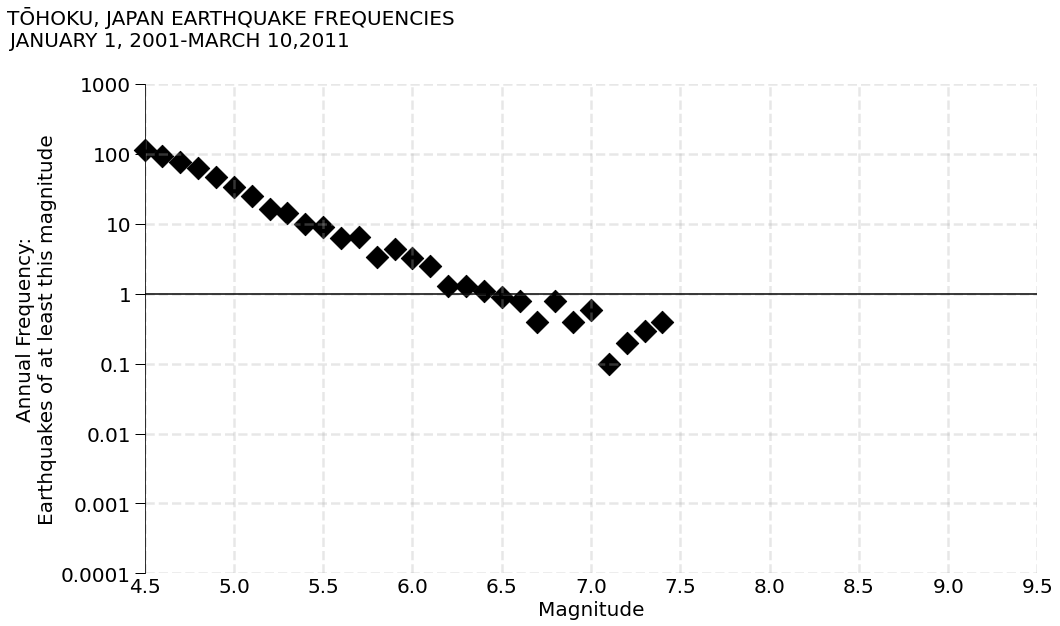

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
df_freq.reset_index().plot.scatter(x = 'Magnitude', 
                                   y ='Yearly Frequency', 
                                   logy=True, 
                                   ax = ax, 
                                   color = 'k', 
                                   s = 250, 
                                   marker = 'D', 
                                   clip_on=False)


plt.xticks(np.arange(4.5,9.6,0.5), size = 20)
plt.yticks(size=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'minor')
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'major', axis = "x")

plt.hlines(1,0,10, color = 'k')

plt.xlim(4.5,9.5)
plt.ylim(0.0001,1000)

plt.grid(linestyle="--", linewidth = 2.5, alpha = 0.3)


plt.ylabel("Annual Frequency:\nEarthquakes of at least this magnitude", size = 20)
plt.xlabel("Magnitude",size = 20)
[ax.spines[i].set_visible(False) for i in ['top','bottom','right']]
plt.suptitle(f"{'TŌHOKU, JAPAN EARTHQUAKE FREQUENCIES'}\n{'JANUARY 1, 2001-MARCH 10,2011':<45}", 
             size = 20, 
             x = 0.2, 
             y = 1)

The chart doesn't exactly match Nate's due to the dataset being a shorter time time period (2000-2011) but it's a close enough match to create a linear model. 

In [13]:
lm = LinearRegression()
X = np.array(df_freq.reset_index()['Magnitude']).reshape(-1,1)
y = np.log10(df_freq['Yearly Frequency'])
s = df_freq['Yearly Frequency']
lm.fit(X,y,s)
pred = 10 ** lm.predict(np.arange(0,11,1).reshape(-1,1)) 

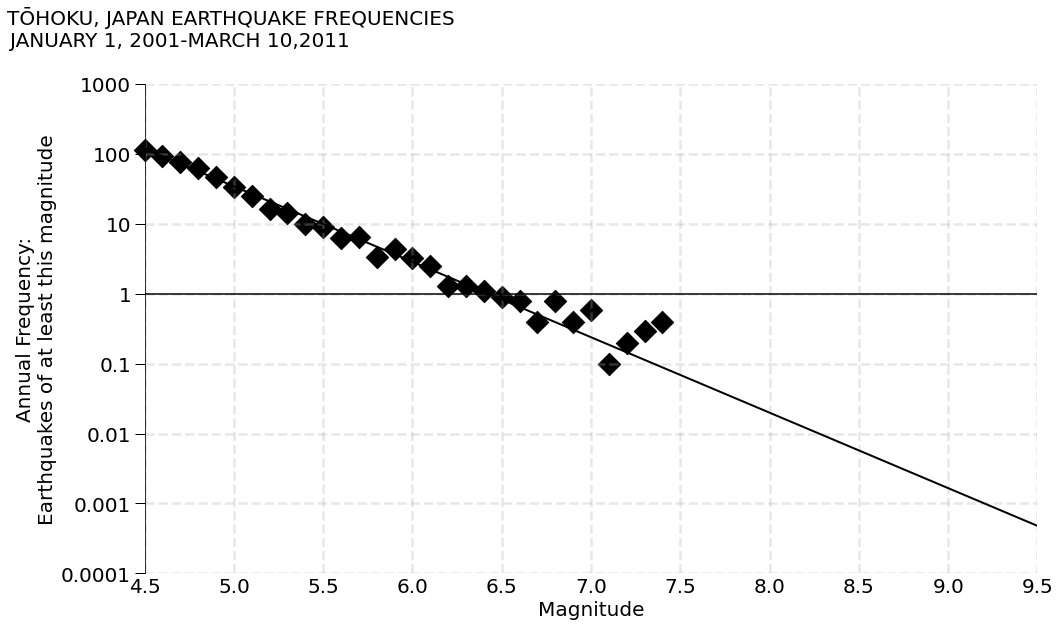

In [14]:
#hide_input
fig, ax = plt.subplots(figsize=(16,9))
df_freq.reset_index().plot.scatter(x = 'Magnitude', 
                                   y ='Yearly Frequency', 
                                   logy=True, 
                                   ax = ax, 
                                   color = 'k', 
                                   s = 250, 
                                   marker = 'D', 
                                   clip_on=False)
plt.plot(np.arange(0,11,1), pred, color = 'k', linewidth = 2)

plt.xticks(np.arange(4.5,9.6,0.5), size = 20)
plt.yticks(size=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'minor')
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'major', axis = "x")

plt.hlines(1,0,10, color = 'k')

plt.xlim(4.5,9.5)
plt.ylim(0.0001,1000)

plt.grid(linestyle="--", linewidth = 2.5, alpha = 0.3)


plt.ylabel("Annual Frequency:\nEarthquakes of at least this magnitude", size = 20)
plt.xlabel("Magnitude",size = 20)
[ax.spines[i].set_visible(False) for i in ['top','bottom','right']]
plt.suptitle(f"{'TŌHOKU, JAPAN EARTHQUAKE FREQUENCIES'}\n{'JANUARY 1, 2001-MARCH 10,2011':<45}", 
             size = 20, 
             x = 0.2, 
             y = 1);

The resulting model is a good approximation to Nate's with the estimated likihood of a magnitude earthquake happening once every 800 years while Nates's linear model predicts an event every 900 years.

![](https://ml.berkeley.edu/blog/static/28adadfec54ae5c331727f412a048fd6/f676f/tut4_earthquake-fit.webp)

## Polynomial

Since I can't find too much info on the polynomial model, but the closest, least complicated model that can match Nate's polynomial model is  
`b4 mag^4 + b3 mag^3 + b2 mag^2 + b1 mag + b0`. This model produces the following graph.

In [15]:
#hide_input
df_freq2 = df_freq.reset_index()
df_freq2['Mag2'] = df_freq2['Magnitude']**2
df_freq2['Mag3'] = df_freq2['Magnitude']**3
df_freq2['Mag4'] = df_freq2['Magnitude']**4
X_range = np.arange(1,11,0.1)
X_test = [[i,
           i**2,
           i**3,
           i**4
          ] for i in X_range]

In [16]:
#hide_input
lm = LinearRegression()
X = df_freq2[['Magnitude','Mag2','Mag3','Mag4']].values
y = np.log10(df_freq['Yearly Frequency'])
s = df_freq2['Yearly Frequency']
lm.fit(X,y,s)
pred = lm.predict(X_test) 
pred = 10**pred

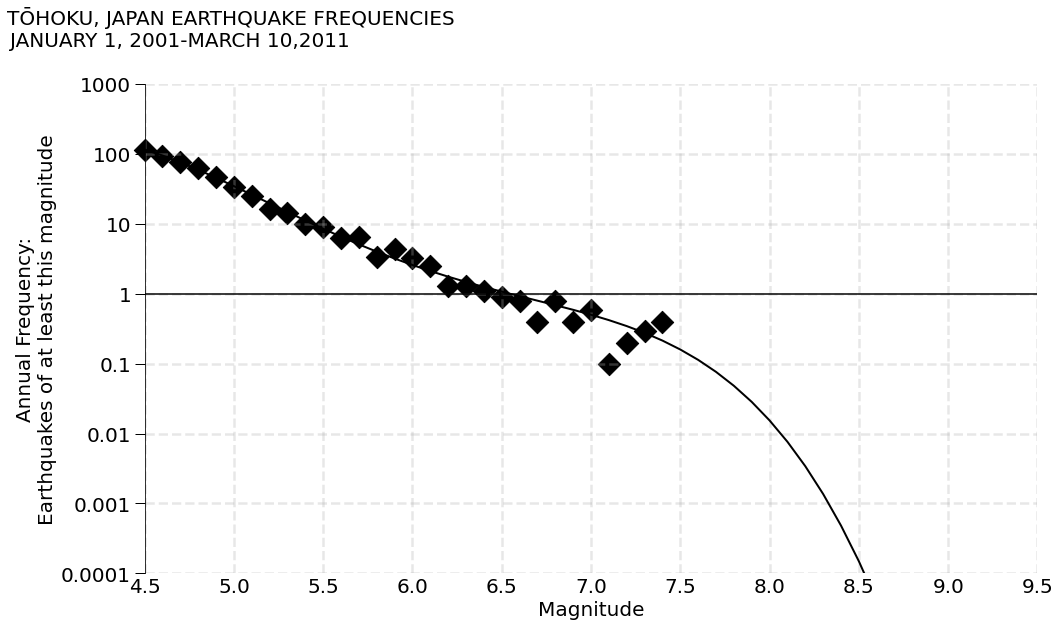

In [17]:
#hide_input
fig, ax = plt.subplots(figsize=(16,9))
df_freq.reset_index().plot.scatter(x = 'Magnitude', 
                                   y ='Yearly Frequency', 
                                   logy=True, 
                                   ax = ax, 
                                   color = 'k', 
                                   s = 250, 
                                   marker = 'D', 
                                   clip_on=False)
plt.plot(X_range, pred, color = 'k', linewidth = 2)

plt.xticks(np.arange(4.5,9.6,0.5), size = 20)
plt.yticks(size=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'minor')
ax.tick_params(width = 1, length = 10, which = 'major')
ax.tick_params(width = 0, length = 0, which = 'major', axis = "x")

plt.hlines(1,0,10, color = 'k')

plt.xlim(4.5,9.5)
plt.ylim(0.0001,1000)

plt.grid(linestyle="--", linewidth = 2.5, alpha = 0.3)


plt.ylabel("Annual Frequency:\nEarthquakes of at least this magnitude", size = 20)
plt.xlabel("Magnitude",size = 20)
[ax.spines[i].set_visible(False) for i in ['top','bottom','right']]
plt.suptitle(f"{'TŌHOKU, JAPAN EARTHQUAKE FREQUENCIES'}\n{'JANUARY 1, 2001-MARCH 10,2011':<45}", 
             size = 20, 
             x = 0.2, 
             y = 1);

#### 